In [1]:
%cd git/kimberley_hail

/home/561/tr2908/git/kimberley_hail


In [2]:
import sys
sys.path.append('../xarray_parcel/')

import os
import dask
import xarray
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from importlib import reload
import modules.parcel_functions as parcel
import modules.nth_hail as nh
import matplotlib.pyplot as plt
import modules.wrf_metadata as wm
from dask.distributed import Client

In [1]:
95 + 101 + 90

286

In [3]:
client = Client()

## Settings

In [4]:
BC2019_file = 'data/GMI_BC2019_20_hailcases_AUST.txt'        # Data file containing Bang & Cecil 2019 hail detections.
sims_dir = '/g/data/up6/tr2908/kimberley_hail/simulations/'  # Directory where simulations are held.
wrf_dir = '/g/data/up6/tr2908/kimberley_hail/WRF_v4.3/'      # Directory with compiled WRF and basic namelist files.
adiabat_lookups = '/g/data/w42/tr2908/aus400_hail/'          # Parcel adiabat lookup dir.

In [5]:
plt.show()                                                   # Start the plotting engine.
plt.rcParams['font.size'] = 14                               # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False             # Don't use offsets in plots.
_ = dask.config.set({'array.slicing.split_large_chunks': False}) # Allow for large dask chunks.

## Event selection

In [6]:
hail_detections = pd.read_csv(BC2019_file, sep='\s+')
hail_detections = hail_detections[hail_detections.LAT > -19]           # Select only northern-Australia detections.
hail_detections = hail_detections[hail_detections.FLAG == 1]           # Select detections that were not flagged for snow/surface features.
hail_detections = hail_detections[hail_detections.P_hail_BC2019 > 0.5] # Select only detections with Bang & Cecil 2019 hail probability over 50%.
hail_detections = hail_detections.reset_index(drop=True)
print(f'The dataset contains {len(hail_detections)} hail detections.')

The dataset contains 44 hail detections.


We simulate the hour before the event, the hour of the event and the hour after the event, so each event has 3 hours of simulation time. The start time is shifted back 12 hours to give a 12 hour spin-up time. Total simulation time is then 15 hours per event.

In [7]:
hail_detections['event_time'] = pd.to_datetime((hail_detections.YEAR.astype(str) + '-' + 
                                                hail_detections.MONTH.astype(str) + '-' + 
                                                hail_detections.DAY.astype(str) + ' ' +
                                                hail_detections.HOUR.astype(str) + ':' + 
                                                hail_detections.MIN.astype(str)))
hail_detections['start_time'] = (hail_detections.event_time - np.timedelta64(13, 'h')).dt.floor('H')
hail_detections['end_time'] = (hail_detections.event_time + np.timedelta64(1, 'h')).dt.ceil('H')
hail_detections['start_time'] = hail_detections.start_time.dt.strftime('%Y-%m-%d_%H:%M:00')
hail_detections['end_time'] = hail_detections.end_time.dt.strftime('%Y-%m-%d_%H:%M:00')

Here is a map showing the locations of the hail detections we study here.

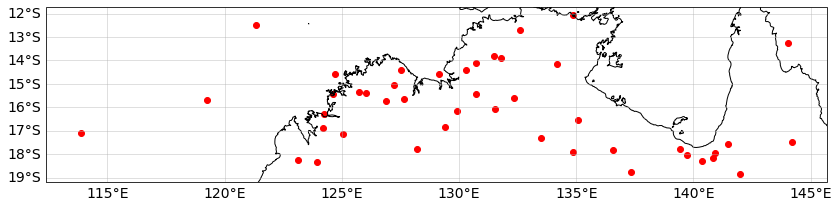

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14,8))
ax.scatter(hail_detections.LON, hail_detections.LAT, transform=ccrs.PlateCarree(), color='red')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
gl.top_labels = gl.right_labels = False
ax.coastlines()
plt.show()

## Simulation setup

Run the following code to create a directory for each simulation and set up all the namelist files to use the correct location and times.

In [2]:
#for i, row in hail_detections.iterrows():
#    nh.set_up_WRF(lat=row.LAT, lon=row.LON, year=row.YEAR, month=row.MONTH, day=row.DAY, hour=row.HOUR, minute=row.MIN, 
#                  start_time=row.start_time, end_time=row.end_time, wrf_dir=wrf_dir, sims_dir=sims_dir)

To run WPS for each simulation:

```
cd /g/data/up6/tr2908/hail_kimberley/simulations/
for i in lat*; do cd $i/WPS; echo `pwd`; qsub ~/git/kimberley_hail/scripts/run_WPS.sh; cd ../../; done
```

Once WPS has run on all, then do:

```
cd /g/data/up6/tr2908/hail_kimberley/simulations/
for i in lat*/WRF/*; do cd $i; echo `pwd`; qsub ~/git/kimberley_hail/scripts/run_WRF.sh; cd ../../../; done
```

Here are details of the simulation setup, which is simply moved and placed with each hail detection at the centre spatially and temporally.

In [ ]:
row = hail_detections.iloc[1,]
dr = nh.sim_directory(lat=row.LAT, lon=row.LON, year=row.YEAR, month=row.MONTH, day=row.DAY, hour=row.HOUR, minute=row.MIN, sims_dir=sims_dir)
wm.analyse_wrfinput(f'{dr}/WRF/wrfinput_d03')

## Read data

In [ ]:
%%time
all_dat = []
spinup_start_idx = 144

for i, row in hail_detections.iterrows():
    dr = nh.sim_directory(lat=row.LAT, lon=row.LON, year=row.YEAR, month=row.MONTH, day=row.DAY, hour=row.HOUR, minute=row.MIN, sims_dir=sims_dir)
    event_basic = xarray.open_mfdataset(f'{dr}/WRF/basic*.nc', parallel=True)
    event_conv = xarray.open_mfdataset(f'{dr}/WRF/conv*.nc', parallel=True) 
    event_dat = xarray.merge([event_basic, event_conv])
    
    # Add event information.
    event_dat['event'] = i+1
    event_dat = event_dat.expand_dims('event')
    event_dat = event_dat.assign_coords({'event': event_dat.event})
    
    # Remove the spin-up time from the event.
    event_dat = event_dat.isel(time=slice(spinup_start_idx, None))
    event_dat = event_dat.sortby('time')
    event_dat['timestep'] = ('time', np.arange(len(event_dat.time)))
    event_dat = event_dat.swap_dims({'time': 'timestep'}).reset_coords()
    all_dat.append(event_dat)

In [ ]:
dat = xarray.combine_nested(all_dat, concat_dim='event', combine_attrs='drop_conflicts')

In [ ]:
_ = (dat.hailcast_diam_max.max(['timestep']) > 25).plot(col='event', col_wrap=11)

In [ ]:
max_hail_size = dat.hailcast_diam_max.max(['west_east', 'south_north', 'timestep'])
hail_events = max_hail_size.where(max_hail_size > 0, drop=True).event
nohail_events = max_hail_size.where(max_hail_size == 0, drop=True).event
assert not np.any(np.isin(nohail_events, hail_events)), 'Hail/no-hail events overlap.'

In [ ]:
_ = dat.sel(event=hail_events).melting_level.mean(['south_north', 'west_east']).plot(hue='event', x='timestep')
plt.show()
_ = dat.sel(event=nohail_events).melting_level.mean(['south_north', 'west_east']).plot(hue='event', x='timestep')
plt.show()

In [ ]:
_ = (dat.hailcast_diam_max > 25).sum(['west_east', 'south_north']).plot(x='timestep', col='event', col_wrap=4)

Ideas:
- We should try more microphysics schemes! Including the NSSL scheme which diagnoses hail size at the surface and in the column. 
- In [this paper](https://www.sciencedirect.com/science/article/pii/S0169809522001296) HAILCAST was tested in Croatia with various schemes; they also ran at 1 km and said they found false alarms from HAILCAST, which they related to the updraft threshold for when HAILCAST is run. HAILCAST was designed for 3km runs and uses a 10 ms-1 updraft threshold; at 1km they used 18 ms-1 as an updated threshold. 
- In [Johnson MWR 2019](https://doi.org/10.1175/MWR-D-18-0398.1) different microphysics schemes are tested for idealised and real hail cases. The original P3 scheme does not perform so well, which is why the P3-3M scheme (used here) was developed.